<a href="https://colab.research.google.com/github/RgomezRo/capstone/blob/main/Time%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [494]:
AUTORUNTHISWONDERFULLPROGRAM = True

In [566]:
pip install squarify

In [495]:
!pip install wget

In [496]:
!pip install calmap

In [497]:
#@title imports

### importamos librerías

'''
instalar:
- plotly
- calmap
- folium
- wget
'''

#analisis
import pandas as pd 
import numpy as np
import sys
from scipy.stats import kurtosis, skew 
from scipy import stats
from google.colab import output
import datetime as dt

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

#visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calmap
import folium

#paletas
confirmados='#393e46'
fallecidos='#ff2e63'

import wget
import os
import json

# Data Loading

In [498]:
#@title Funcion de lectura de data sets read_FAO()
import requests 
import os 
def read_FAO(fileName):
	
	Database = fileName + ".csv"

	if(os.path.isfile(Database)!=True):

		file_url = "https://fenixservices.fao.org/faostat/static/bulkdownloads/"+fileName+".zip"
			
		r = requests.get(file_url, stream = True) 

		with open("temporalFile.zip", "wb") as file: 
			for block in r.iter_content(chunk_size = 1024): 
				if block: 
					file.write(block) 
			
		!unzip temporalFile.zip 

			
	df = pd.read_csv(Database, encoding = "ISO-8859-1")

	return df




# Key differences between new and old Food Balance Sheet (FBS) methodology:

The key difference between the new and old food balances (FBS) methodologies is **the absence of a balancer variable.**

 In the past, one of the components of the FBS (often stocks, industrial
utilization or feed) would take on **the outstanding unbalanced mounts thus inheriting all the statistical errors.**

With the new methodology, the imputations for the FBS components (the data
of which are often not provided by countries) are **generated by dedicated modules; and a
balancing mechanism** will then proportionally spread the imbalances out among all the
components.

The most important output of the FBS is the Dietary Energy Supply (DES) in kilocalories per
person per day in a given country. This DES is based on the imputations generated by the
dedicated new food module. 

This module, in year t, is heavily influenced by food in year t-1,
and considering that the other variables in the module are changes in real GDP, population, and
commodity demand elasticity – all of which do not usually exhibit large variations from one
year to another - **the food quantities can be assumed to be comparable between the two methodologies.** 

However, the FBS balancing mechanism, in allocating all available quantities
to the food component for ‘food only’ commodities (e.g. meat of cattle), may result in
discrepancies with the old time series. Further analysis of this still needs to be carried out. 


In [499]:

### leer origenes

df_food_balances = read_FAO("FoodBalanceSheets_E_All_Data_(Normalized)")

df_emissions = read_FAO("Emissions_Totals_E_All_Data_(Normalized)")

df_emissions_share = read_FAO("Environment_Emissions_by_Sector_E_All_Data_(Normalized)")


df_food_transport = read_FAO("Environment_Transport_E_All_Data_(Normalized)")

df_waste_disposal = read_FAO("Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized)")





Archive:  temporalFile.zip
  inflating: Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv  
  inflating: Environment_Emissions_by_Sector_E_Flags.csv  


In [500]:
df_food_balances["Year"] = pd.to_datetime(df_food_balances.Year, format='%Y')
df_emissions["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_emissions_share["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_food_transport["Year"] = pd.to_datetime(df_food_transport.Year, format='%Y')
df_waste_disposal["Year"] = pd.to_datetime(df_waste_disposal.Year, format='%Y')

In [502]:
## TO DO FILTRAR SOLO DATOS DE POSTPRODUCCION df_emissions_share = df_emissions_share[df_emissions_share["Element"]]

In [503]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [504]:
### lectura generada por pere
df_cluster_paises = pd.read_csv("/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Cluster_Paises.csv", encoding = "ISO-8859-1")

In [509]:
#@title Function to show nulls and gaps in data : show_gaps_data 
def show_gaps_data(df_input,):
  # create a smaller df

  df_input["MeasuredItem"]= df_input["Item"] + "-"+ df_input["Element"]

  # in order to show and fill na we aggregate a little bit the info

  short_df = df_input[["Year", "Value","MeasuredItem"]]


  # show  gaps in the data

  gb_df_ = short_df.pivot_table(index = ["Year"], columns = ['MeasuredItem'], values = "Value", aggfunc = sum).isnull()
  #gb_df_= gb_df_.fillna(0)

  order_of_columns = list(gb_df_.sum().sort_values().index)
  
  gb_df_ = gb_df_[order_of_columns]


  plt.figure(figsize = (20, 10))
  plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
  plot.set_title("Null values in dataset");

  
  return df_input







In [506]:
#@title Data description function DataDesc
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [507]:
#@title Function for null nnalysis : Null_Count()

def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]





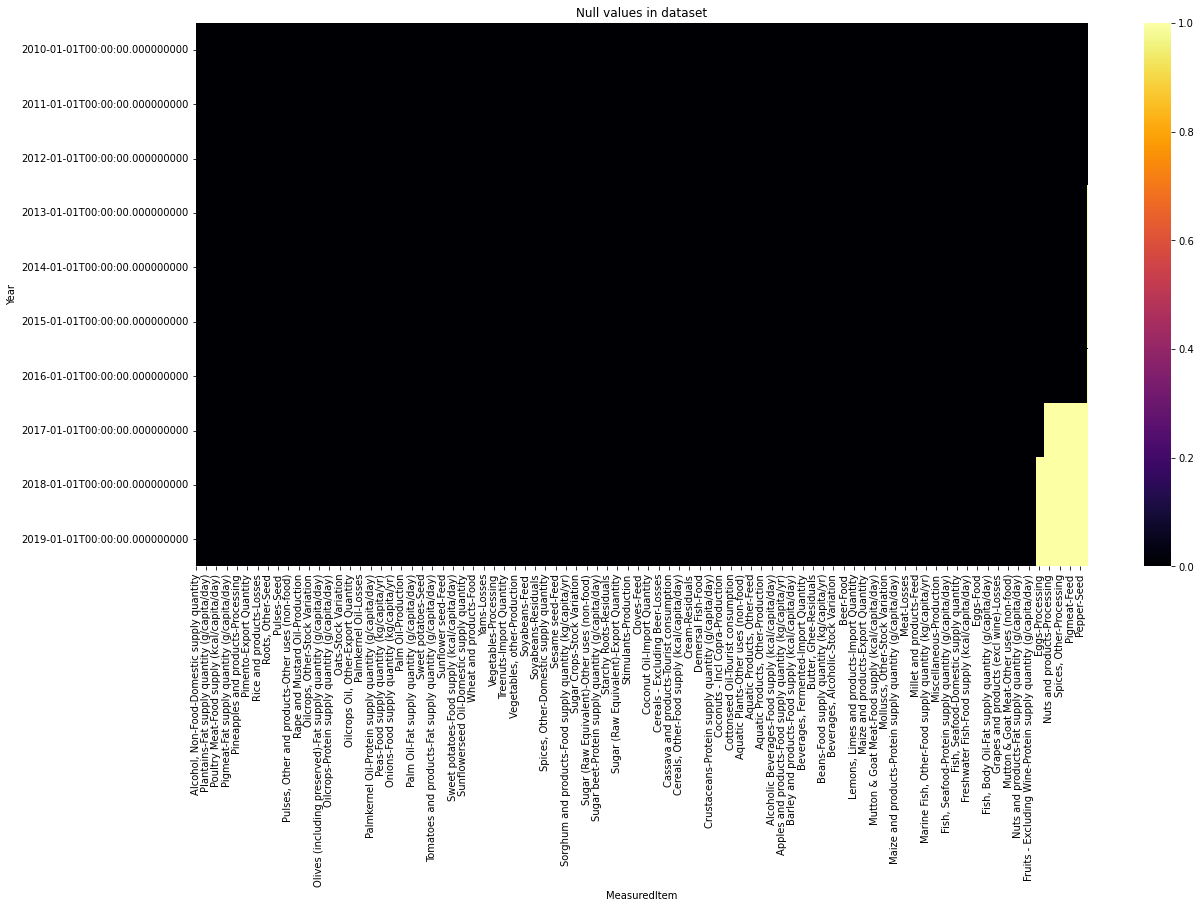

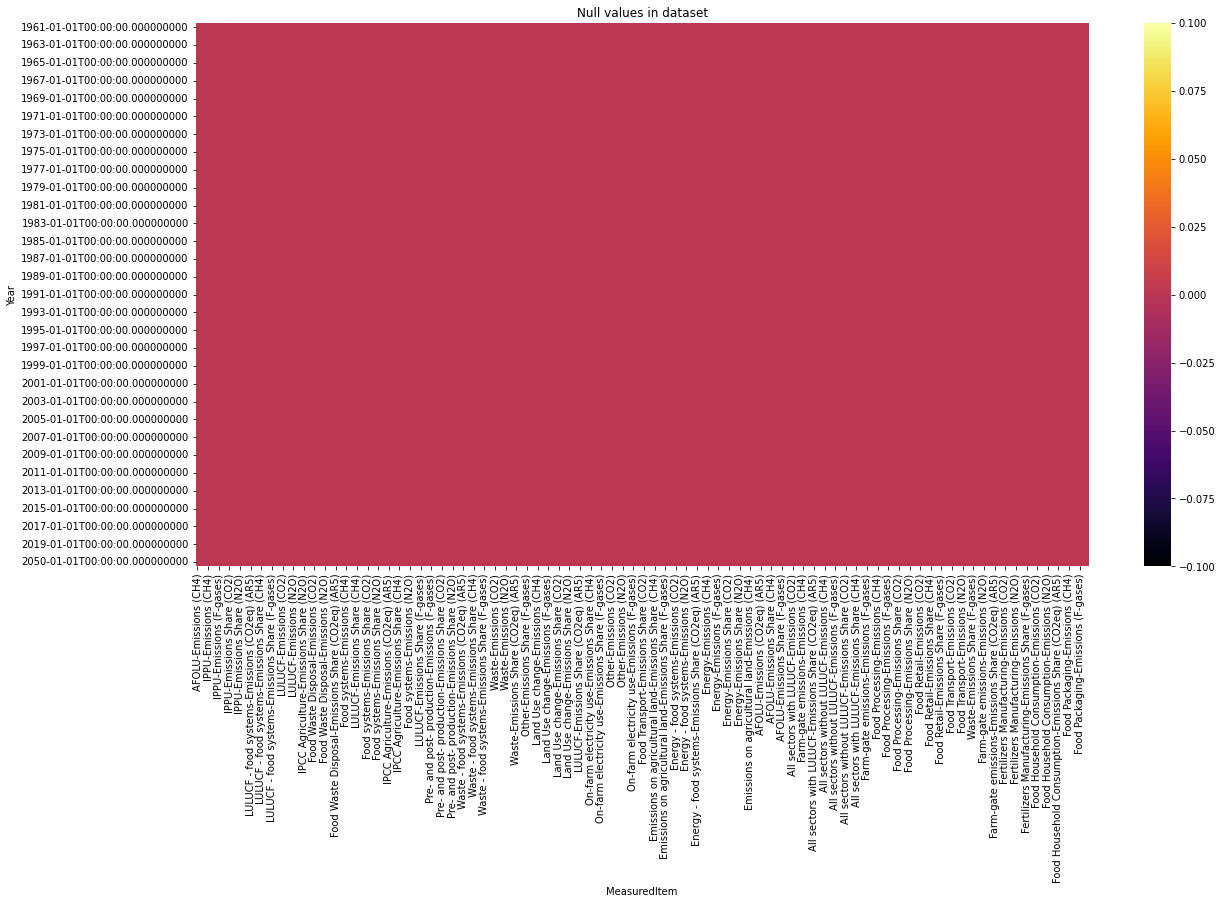

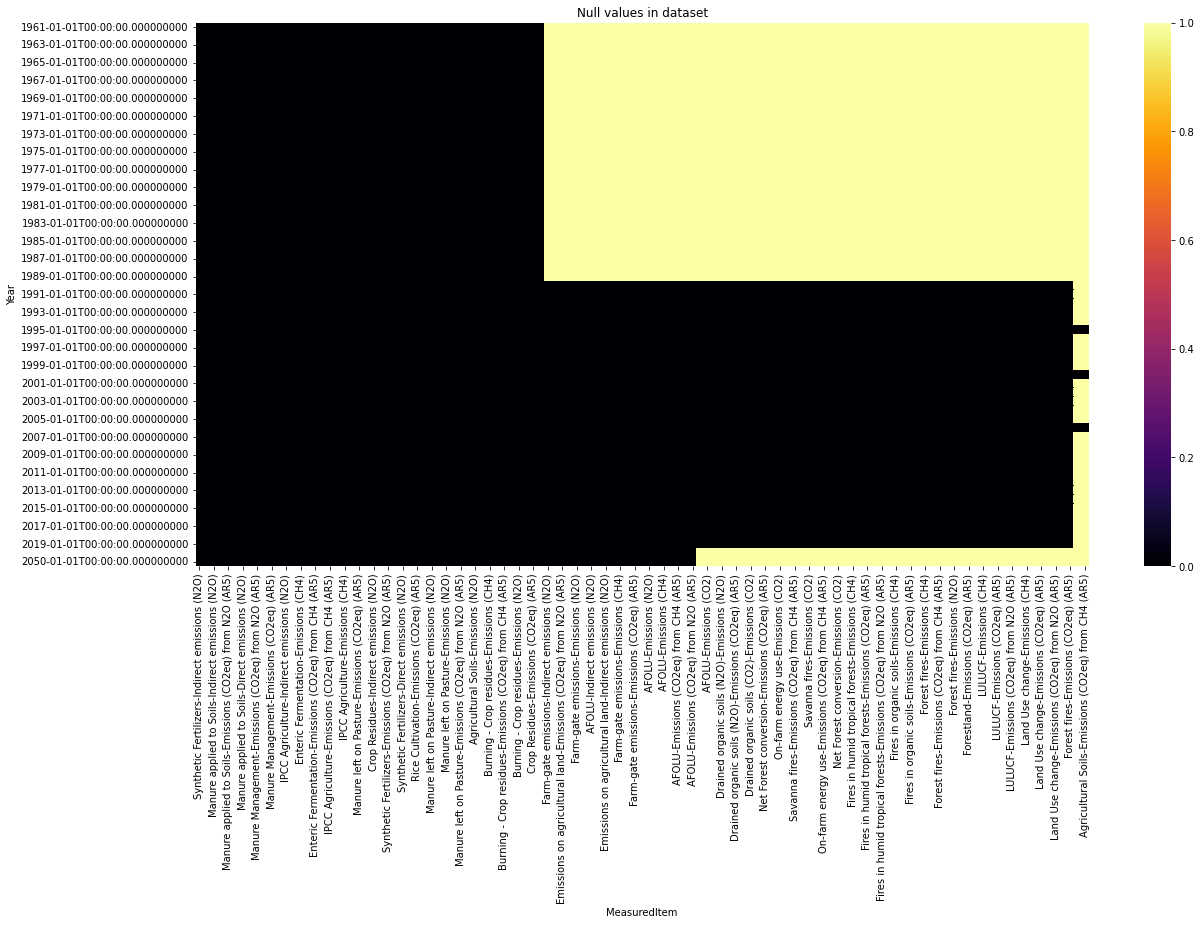

In [510]:
### mostrar donde se encuentran los gaps, tanto nulos como lineas inexistentes
df_food_balances = show_gaps_data(df_food_balances)
df_emissions_share = show_gaps_data(df_emissions_share)
df_emissions = show_gaps_data(df_emissions)


In [511]:
DataDesc(df_food_balances)

### Vemos que tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (2975297, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,216,2,2,2,7.73
1,Area,object,0,216,Afghanistan,Afghanistan,Afghanistan,7.73
2,Item Code,int64,0,123,2501,2501,2501,6.88
3,Item,object,0,120,Population,Population,Population,6.82
4,Element Code,int64,0,18,511,511,511,3.98
5,Element,object,0,18,Total Population - Both sexes,Total Population - Both sexes,Total Population - Both sexes,3.98
6,Year Code,int64,0,10,2010,2011,2012,3.32
7,Year,datetime64[ns],0,10,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,3.32
8,Unit,object,0,5,1000 persons,1000 persons,1000 persons,1.37
9,Value,float64,63553,68992,29186.0,30117.0,31161.0,7.50


In [512]:
df_food_balances.groupby(["Element","Unit"]).count()

,,Area Code,Area,Item Code,Item,Element Code,Year Code,Year,Value,Flag,MeasuredItem
Element,Unit,,,,,,,,,,
Domestic supply quantity,1000 tonnes,247541,247541,247541,247541,247541,247541,247541,247541,247541,247541
Export Quantity,1000 tonnes,204361,204361,204361,204361,204361,204361,204361,203224,204361,204361
Fat supply quantity (g/capita/day),g/capita/day,232626,232626,232626,232626,232626,232626,232626,232626,232626,232626
Feed,1000 tonnes,88461,88461,88461,88461,88461,88461,88461,78185,88461,88461
Food,1000 tonnes,227822,227822,227822,227822,227822,227822,227822,227410,227822,227822
Food supply (kcal/capita/day),kcal/capita/day,232318,232318,232318,232318,232318,232318,232318,232318,232318,232318
Food supply quantity (kg/capita/yr),kg,227378,227378,227378,227378,227378,227378,227378,227378,227378,227378
Import Quantity,1000 tonnes,236893,236893,236893,236893,236893,236893,236893,236702,236893,236893
Losses,1000 tonnes,113402,113402,113402,113402,113402,113402,113402,108298,113402,113402


In [513]:
DataDesc(df_emissions)
### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (1261741, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,280,2,2,2,8.04
1,Area,object,0,280,Afghanistan,Afghanistan,Afghanistan,8.04
2,Item Code,int64,0,25,5058,5058,5058,4.43
3,Item,object,0,25,Enteric Fermentation,Enteric Fermentation,Enteric Fermentation,4.43
4,Element Code,int64,0,8,7225,7225,7225,2.91
5,Element,object,0,8,Emissions (CH4),Emissions (CH4),Emissions (CH4),2.91
6,Year Code,int64,0,61,1961,1962,1963,5.73
7,Year,datetime64[ns],0,61,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,5.73
8,Source Code,int64,0,2,3050,3050,3050,0.36
9,Source,object,0,2,FAO TIER 1,FAO TIER 1,FAO TIER 1,0.36


In [514]:
df_emissions[df_emissions["Element"]=="Emissions (CO2eq) (AR5)"].groupby(["Element","Item","Unit"]).count()

Area Code  \
Element                 Item                            Unit                    
Emissions (CO2eq) (AR5) AFOLU                           kilotonnes       8525   
                        Agricultural Soils              kilotonnes      16044   
                        Burning - Crop residues         kilotonnes      14277   
                        Crop Residues                   kilotonnes      14366   
                        Drained organic soils           kilotonnes       5178   
                        Drained organic soils (CO2)     kilotonnes       4384   
                        Drained organic soils (N2O)     kilotonnes       5216   
                        Emissions on agricultural land  kilotonnes       8539   
                        Enteric Fermentation            kilotonnes      15679   
                        Farm-gate emissions             kilotonnes       8449   
                        Fires in humid tropical forests kilotonnes       7915   
                        Fires in organic soils          kilotonnes       7932   
                        Forest fires                    kilotonnes       8114   
                        Forestland                      kilotonnes       8957   
                        IPCC Agriculture                kilotonnes      16956   
                        LULUCF                          kilotonnes      10043   
                        Land Use change                 kilotonnes       8035   
                        Manure Management               kilotonnes      15718   
                        Manure applied to Soils         kilotonnes      14997   
                        Manure left on Pasture          kilotonnes      14992   
                        Net Forest conversion           kilotonnes       8872   
                        On-farm energy use              kilotonnes       7568   
                        Rice Cultivation                kilotonnes       9844   
                        Savanna fires                   kilotonnes       8612   
                        Synthetic Fertilizers           kilotonnes      12391   

                                                                     Area  \
Element                 Item                            Unit                
Emissions (CO2eq) (AR5) AFOLU                           kilotonnes   8525   
                        Agricultural Soils              kilotonnes  16044   
                        Burning - Crop residues         kilotonnes  14277   
                        Crop Residues                   kilotonnes  14366   
                        Drained organic soils           kilotonnes   5178   
                        Drained organic soils (CO2)     kilotonnes   4384   
                        Drained organic soils (N2O)     kilotonnes   5216   
                        Emissions on agricultural land  kilotonnes   8539   
                        Enteric Fermentation            kilotonnes  15679   
                        Farm-gate emissions             kilotonnes   8449   
                        Fires in humid tropical forests kilotonnes   7915   
                        Fires in organic soils          kilotonnes   7932   
                        Forest fires                    kilotonnes   8114   
                        Forestland                      kilotonnes   8957   
                        IPCC Agriculture                kilotonnes  16956   
                        LULUCF                          kilotonnes  10043   
                        Land Use change                 kilotonnes   8035   
                        Manure Management               kilotonnes  15718   
                        Manure applied to Soils         kilotonnes  14997   
                        Manure left on Pasture          kilotonnes  14992   
                        Net Forest conversion           kilotonnes   8872   
                        On-farm energy use              kilotonnes   7568   
                        Rice Cul

In [515]:
DataDesc(df_cluster_paises)
### Vemos que el cluster tiene 3 divisiones

Dataset Shape: (205, 3)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Unnamed: 0,int64,0,205,0,1,2,7.68
1,Area,object,0,205,Afghanistan,Albania,Algeria,7.68
2,cluster,int64,0,3,1,1,1,1.31


In [516]:
df_cluster_paises.head(6)

# ejemplo de dos de ellas

,Unnamed: 0,Area,cluster
0,0,Afghanistan,1
1,1,Albania,1
2,2,Algeria,1
3,4,Angola,1
4,5,Anguilla,0
5,6,Antigua and Barbuda,0


In [517]:
#@title Función de interpolación de nulos: my_interp()
def my_interp(x):
    if x.notnull().sum() > 1:
      return x.interpolate(method='nearest').ffill().bfill()
    else:
      if(x.isna().all()):
        return x.fillna(0)
      else:
        return x.ffill().bfill()

In [518]:
#@title Funcion de generación de dataset basados en datos de la FAO transpuestos: generate_columns_for_dataset()
def generate_columns_for_dataset(old_df, columns_to_transpose,columns_to_transpose_by,column_with_value,pathToGenerateConfigFile,auto_run = False):
  filtering_list = []
  df_filtered = old_df
  continue_with_old_config = "N"
  df_to_return = pd.DataFrame() 
  

  if(os.path.isfile(pathToGenerateConfigFile)):
    if(auto_run):
      continue_with_old_config = "Y"  
    else:
      continue_with_old_config = input("\r\nYa existe un archivo con este nombre y esta ruta, pulse [Y] si desea recuperarlo:\r\n "   )

  if(continue_with_old_config=="Y" ):
    with open(pathToGenerateConfigFile, "r") as read_file:
   
      df_to_return = pd.read_csv(pathToGenerateConfigFile, encoding = "ISO-8859-1")


  else:  
    for column_index in range(len(columns_to_transpose)): 

      current_column = columns_to_transpose[column_index]
      array_of_measured_items =  df_filtered.groupby(current_column).count().add_suffix("_count").reset_index()[current_column]
      
      output.clear()
      if(column_index != (len(columns_to_transpose)-1)):
        
        display(array_of_measured_items)
        value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
        filtering_list.append(array_of_measured_items[value_to_filter])

      else:

        # this is the last type of row to transpose.
        decision = int(input(" \r\n Introduzca [1] si desea incluir todos los valores de ["+current_column + "]. \r\n Si prefiere filtrar los valores pulse [2]: \r\n" ))
        
        if(decision == 2):

          display(array_of_measured_items)
          value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
          filtering_list.append(array_of_measured_items[value_to_filter])

          
      display(filtering_list)

      if(len(filtering_list)>0):

        for row_index in range(len(filtering_list)):

          row_to_filter = filtering_list[row_index]
          
          col = columns_to_transpose[row_index]
          df_filtered = df_filtered[df_filtered[col]==row_to_filter]
 
    columns_to_generate_prefix = "" 

    if(len(filtering_list)>0):
        for row_index in range(len(filtering_list)):
          row_to_filter = filtering_list[row_index]
          # we only filter if it is NOT the last column (this way we will be able to traspose it correctly)
          #><
          if(row_index < (len(columns_to_transpose)-1)):
            col = columns_to_transpose[row_index]
            df_filtered = df_filtered[df_filtered[col]==row_to_filter]
            columns_to_generate_prefix = (columns_to_generate_prefix + " " + row_to_filter).strip()

    
    last_granularity = columns_to_transpose[-1]
    columns_to_group_by = []
    columns_to_group_by.extend(columns_to_transpose_by)
    columns_to_group_by.append(last_granularity)

    gb_df= df_filtered.groupby(columns_to_group_by).sum().reset_index()
    df_to_return = df_filtered.groupby(columns_to_transpose_by).sum().reset_index()[columns_to_transpose_by]
    
    
    for last_level in gb_df[last_granularity].unique():
      
      column_name = columns_to_generate_prefix+ " " +last_level
      output.clear()
      display("Generating column "+ column_name)
      partial_df_to_merge = gb_df[gb_df[last_granularity]==last_level].copy()

      

      partial_df_to_merge[column_name] = partial_df_to_merge[column_with_value]

       #### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
      partial_df_to_merge[column_name] = partial_df_to_merge.groupby(columns_to_group_by)[column_name].apply(lambda x:my_interp(x))
      
      
      partial_df_to_merge.reset_index()



      list_column_to_use = []
      list_column_to_use.append(column_name)
      list_column_to_use.extend(columns_to_transpose_by) 
      
      partial_df_to_merge_cleaned = partial_df_to_merge[list_column_to_use].copy()
      df_to_return = pd.merge(df_to_return, partial_df_to_merge_cleaned, on = columns_to_transpose_by, how = "left")
  output.clear()
  
  if(continue_with_old_config!="Y"):
    df_to_return.to_csv(pathToGenerateConfigFile,index=False)
  
  display(df_to_return.head(3).T.head(10))    
  
  return df_to_return
    
  
  

    
        
      
    





In [519]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_food.csv"

### if you dont have the file the order of input is 
###    -   n for the question 
###    -   [6] for selection of Element -- Food supply quantity (kg/capita/yr)
###    -   [1] [ALL ITEMS] for selection of Items   

feature_foods = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01,2011-01-01,2012-01-01
Food supply quantity (kg/capita/yr) Alcoholic Beverages,0.11,0.1,0.09
Food supply quantity (kg/capita/yr) Animal fats,1.41,1.41,1.43
Food supply quantity (kg/capita/yr) Apples and products,2.83,2.63,2.62
Food supply quantity (kg/capita/yr) Bananas,0.73,0.92,1.53
Food supply quantity (kg/capita/yr) Barley and products,1.09,1.85,1.3
Food supply quantity (kg/capita/yr) Beer,0.1,0.09,0.09
"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",0.0,0.0,0.0
Food supply quantity (kg/capita/yr) Bovine Meat,4.58,4.66,4.3


In [520]:
### antes veíamos que food balances contenía nulos 

Null_Count(df_food_balances)

,Column,Null_Count,Null_Percent
0,Value,63553,2.136022


In [521]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset,estos nulos corresponden a años para los que no aparece información
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent
0,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",2092,98.031865
1,Food supply quantity (kg/capita/yr) Palm kernels,2072,97.094658
2,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",2054,96.251172
3,Food supply quantity (kg/capita/yr) Cottonseed,2009,94.142455
4,Food supply quantity (kg/capita/yr) Sugar beet,1664,77.975633
5,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,1626,76.194939
6,Food supply quantity (kg/capita/yr) Ricebran Oil,1410,66.073102
7,Food supply quantity (kg/capita/yr) Sorghum and products,1126,52.764761
8,Food supply quantity (kg/capita/yr) Millet and products,1106,51.827554
9,Food supply quantity (kg/capita/yr) Sugar cane,1016,47.610122


In [522]:
#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in feature_foods.columns[2:]:
  output.clear()
  display("Generating column "+column)
  feature_foods[column] = feature_foods.groupby("Area")[column].apply(lambda x:my_interp(x))
      

'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [523]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent


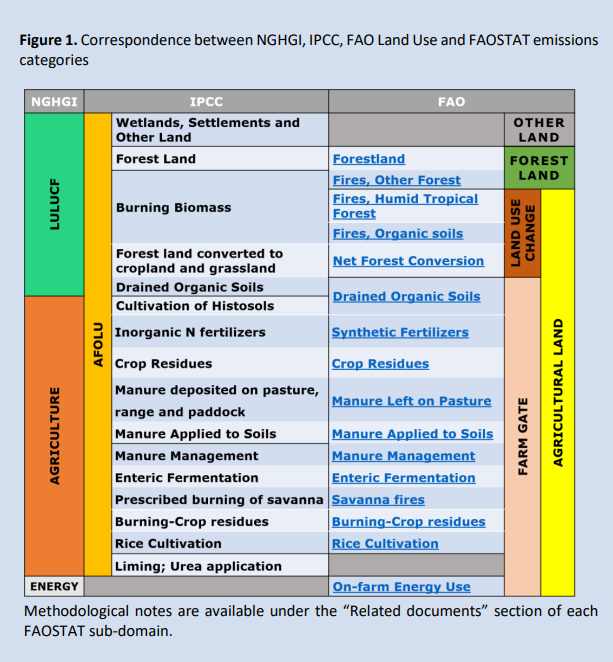



https://fenixservices.fao.org/faostat/static/documents/GT/GT_e.pdf

https://fenixservices.fao.org/faostat/static/documents/GT/Mapping_to_UNFCCC_IPCC.pdf



Los grupos que se observan en la imagen se encuentran tb en el dataset, tenemos que borrarlos.
Por otro lado existe un descuadre de 2 categorías de la imagen que corresponden a 4 items del dataset (Drained Organic Soils x2 y Forest Fires other = savanna fires + forest fires )

In [524]:
df_emissions.groupby(["Item","Item Code","Unit"]).sum().sort_values(by="Item Code")["Value"]

Item                             Item Code  Unit      
LULUCF                           1707       kilotonnes    3.559950e+08
Agricultural Soils               1709       kilotonnes    1.105925e+09
IPCC Agriculture                 1711       kilotonnes    4.156873e+09
Enteric Fermentation             5058       kilotonnes    2.041326e+09
Manure Management                5059       kilotonnes    3.180264e+08
Rice Cultivation                 5060       kilotonnes    4.668202e+08
Synthetic Fertilizers            5061       kilotonnes    3.089999e+08
Manure applied to Soils          5062       kilotonnes    1.152355e+08
Manure left on Pasture           5063       kilotonnes    4.499226e+08
Crop Residues                    5064       kilotonnes    1.150073e+08
Burning - Crop residues          5066       kilotonnes    2.445402e+07
Land Use change                  6516       kilotonnes    1.477192e+09
Drained organic soils            6729       kilotonnes    1.446188e+08
Net Forest conversion 

In [525]:
array_aggregations = []
array_aggregations.append("LULUCF")
array_aggregations.append("Agricultural Soils")
array_aggregations.append("IPCC Agriculture")
array_aggregations.append("Land Use change")
array_aggregations.append("AFOLU")
array_aggregations.append("Emissions on agricultural land")
array_aggregations.append("Farm-gate emissions")

df_emissions= df_emissions.drop(df_emissions[df_emissions["Element"].isin(array_aggregations)].index)

In [526]:
# Una vez sacadas las agrupaciones podemos sumar la huella de carbono de cada pais y año
# sacando todos los datos de dióxido de carbono equivalente

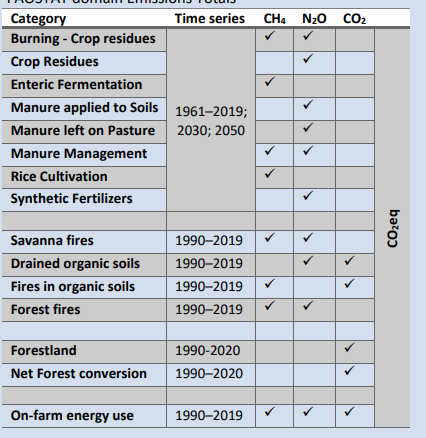

In [527]:
### Como vemos hay datos completos desde 1990. Al tener incompletos los años de 

In [528]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq = generate_columns_for_dataset(df_emissions,["Element"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,1961-01-01,1962-01-01,1963-01-01
Emissions (CO2eq) (AR5),24215.6035,24417.6631,25181.3706


In [529]:
feature_emissions_CO2_eq.head(4 )

,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,24215.6035
1,Afghanistan,1962-01-01,24417.6631
2,Afghanistan,1963-01-01,25181.3706
3,Afghanistan,1964-01-01,25628.0687


In [530]:
feature_emissions_CO2_eq.head(10)

,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,24215.6035
1,Afghanistan,1962-01-01,24417.6631
2,Afghanistan,1963-01-01,25181.3706
3,Afghanistan,1964-01-01,25628.0687
4,Afghanistan,1965-01-01,26219.4802
5,Afghanistan,1966-01-01,27125.8129
6,Afghanistan,1967-01-01,27410.6202
7,Afghanistan,1968-01-01,28319.0168
8,Afghanistan,1969-01-01,28136.2565
9,Afghanistan,1970-01-01,28383.2813


In [531]:
### For emissions we need to transform the data to a per capita amd maybe more operations to be similar to the other columns dimensions
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_poblacion.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [16] [Total Population] for selection of [Element]
###    -   [1] Para la selección de todos los [Item] 

feature_poblation = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01,2011-01-01,2012-01-01
Total Population - Both sexes Population,29186.0,30117.0,31161.0


In [532]:
#@title Generación de producto cartesiano { display-mode: "form" }
#@title
feature_foods["Year"] = pd.to_datetime(feature_foods.Year, format='%Y-%m-%d')
feature_emissions_CO2_eq["Year"] = pd.to_datetime(feature_emissions_CO2_eq.Year, format='%Y-%m-%d')
feature_poblation["Year"] = pd.to_datetime(feature_poblation.Year, format='%Y-%m-%d')

In [533]:
#@title
### Before merging, in order to obtain a little bit more of data we would create a cartesian product
min_date=feature_foods["Year"].min()
display(min_date)
max_date=feature_foods["Year"].max()
display(max_date)
unique_areas = sorted(list(feature_foods["Area"].unique()))
date_range = pd.date_range(min_date, max_date, freq = "Y")
print("We have a total of {} years".format(len(date_range)))

cartesian_product = pd.MultiIndex.from_product([date_range,unique_areas], names = ["Year", "Area"])
cartesian_product


Timestamp('2010-01-01 00:00:00')

Timestamp('2019-01-01 00:00:00')

We have a total of 9 years


MultiIndex([('2010-12-31',                        'Afghanistan'),
            ('2010-12-31',                             'Africa'),
            ('2010-12-31',                            'Albania'),
            ('2010-12-31',                            'Algeria'),
            ('2010-12-31',                           'Americas'),
            ('2010-12-31',                             'Angola'),
            ('2010-12-31',                'Antigua and Barbuda'),
            ('2010-12-31',                          'Argentina'),
            ('2010-12-31',                            'Armenia'),
            ('2010-12-31',                               'Asia'),
            ...
            ('2018-12-31',                            'Vanuatu'),
            ('2018-12-31', 'Venezuela (Bolivarian Republic of)'),
            ('2018-12-31',                           'Viet Nam'),
            ('2018-12-31',                     'Western Africa'),
            ('2018-12-31',                       'Western As

In [534]:
#@title
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df["Year"] =  pd.to_datetime(df_food_balances["Year"], format='%Y-%m-%d')
display(full_df.head())
full_df = pd.merge(full_df, feature_foods, on = ['Area','Year'], how = 'left')

full_df[full_df["Area"]== "Western Europe"].head()

,Year,Area
0,2010-01-01,Afghanistan
1,2011-01-01,Africa
2,2012-01-01,Albania
3,2013-01-01,Algeria
4,2014-01-01,Americas


,Year,Area,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,...,"Food supply quantity (kg/capita/yr) Molluscs, Other",Food supply quantity (kg/capita/yr) Palm kernels,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals"
209,2010-01-01,Western Europe,104.97,12.45,15.71,7.56,0.43,68.96,4.77,18.46,...,3.29,0.0,4.82,0.0,0.0,0.03,0.00,0.0,0.0,0.0
423,2017-01-01,Western Europe,103.96,13.05,14.92,9.82,0.92,68.11,4.45,16.92,...,2.31,0.0,4.66,0.0,0.0,0.01,0.03,0.0,0.0,0.0
637,2011-01-01,Western Europe,110.61,11.98,15.74,7.86,0.33,69.81,4.67,18.17,...,3.39,0.0,5.14,0.0,0.0,0.03,0.00,0.0,0.0,0.0
851,2011-01-01,Western Europe,110.61,11.98,15.74,7.86,0.33,69.81,4.67,18.17,...,3.39,0.0,5.14,0.0,0.0,0.03,0.00,0.0,0.0,0.0
1065,2013-01-01,Western Europe,102.63,12.22,17.29,8.28,0.39,64.64,6.06,17.78,...,2.71,0.0,4.68,0.0,0.0,0.04,0.04,0.0,0.0,0.0


In [535]:
#@title
### Mezclamos los dos datasets cogiendo de base el de food balances
display(full_df.head()) 
display(feature_emissions_CO2_eq.head())
                   


,Year,Area,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,...,"Food supply quantity (kg/capita/yr) Molluscs, Other",Food supply quantity (kg/capita/yr) Palm kernels,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals"
0,2010-01-01,Afghanistan,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
1,2011-01-01,Africa,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,...,0.05,0.0,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0
2,2012-01-01,Albania,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,...,0.31,0.0,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0
3,2013-01-01,Algeria,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,...,0.02,0.0,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0
4,2014-01-01,Americas,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,...,1.45,0.0,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0


,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,24215.6035
1,Afghanistan,1962-01-01,24417.6631
2,Afghanistan,1963-01-01,25181.3706
3,Afghanistan,1964-01-01,25628.0687
4,Afghanistan,1965-01-01,26219.4802


In [536]:
#@title
Null_Count(full_df).head(7)

,Column,Null_Count,Null_Percent
0,Food supply quantity (kg/capita/yr) Rice and products,5,0.259605
1,Food supply quantity (kg/capita/yr) Tea (including mate),5,0.259605
2,Food supply quantity (kg/capita/yr) Groundnuts,5,0.259605
3,Food supply quantity (kg/capita/yr) Cloves,5,0.259605
4,Food supply quantity (kg/capita/yr) Cassava and products,5,0.259605
5,"Food supply quantity (kg/capita/yr) Beverages, Fermented",5,0.259605
6,Food supply quantity (kg/capita/yr) Beans,5,0.259605


In [537]:
#@title
full_df[full_df["Food supply quantity (kg/capita/yr) Animal fats"].isna()].T.head(2)


,397,455,669,883,1097
Year,2011-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00
Area,Sudan,Burundi,Burundi,Burundi,Burundi


In [538]:
#@title
### sudan y burundi son los que tienen todos los valores a nulo, de hecho lo podemos comprobar fácilmente
display(Null_Count(full_df[~full_df["Area"].isin(["Sudan","Burundi"])]))

## intrapolamos el rellenado de nulos otra vez por area

#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in full_df.columns[2:]:
  output.clear()
  display("Generating column "+column)
  full_df[column] = full_df.groupby("Area")[column].apply(lambda x:my_interp(x))


'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [539]:
#@title
Null_Count(full_df)

,Column,Null_Count,Null_Percent


In [540]:
feature_emissions_CO2_eq = pd.merge( feature_poblation,feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')
feature_emissions_CO2_eq.T
# los huecos son por las estimaciones de 1961-1990 y de las predicciones hasta 2050 [Estos datos se eliminan a futuro]

,0,1,2,3,4,5,6,7,8,9,...,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133
Area,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,...,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,...,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00
Total Population - Both sexes Population,29186.0,30117.0,31161.0,32270.0,33371.0,34414.0,35383.0,36296.0,37172.0,38042.0,...,12698.0,12894.0,13115.0,13350.0,13587.0,13815.0,14030.0,14237.0,14439.0,14645.0
Emissions (CO2eq) (AR5),88621.6777,88320.7611,87522.2175,162085.5354,89409.6461,83417.4102,85478.8021,84733.4835,82822.85,86556.2298,...,131027.1948,130345.9212,126491.9724,122262.7537,112751.1942,119333.0309,341985.5122,342894.3098,344872.6953,345776.2239


In [541]:
#@title Convertimos las emisiones a per capita 
feature_emissions_CO2_eq["feature_emissions_CO2_eq"] = feature_emissions_CO2_eq[" Emissions (CO2eq) (AR5)"]/feature_emissions_CO2_eq["Total Population - Both sexes Population"]	

In [542]:
feature_emissions_CO2_eq.head()
feature_emissions_CO2_eq=feature_emissions_CO2_eq.drop(["Total Population - Both sexes Population"," Emissions (CO2eq) (AR5)"],axis=1)

In [543]:
feature_emissions_CO2_eq.head()

,Area,Year,feature_emissions_CO2_eq
0,Afghanistan,2010-01-01,3.036445
1,Afghanistan,2011-01-01,2.932588
2,Afghanistan,2012-01-01,2.808710
3,Afghanistan,2013-01-01,5.022793
4,Afghanistan,2014-01-01,2.679262


In [544]:
df_with_target = pd.merge(full_df, feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')

In [545]:
Null_Count(df_with_target).head(4)

,Column,Null_Count,Null_Percent
0,feature_emissions_CO2_eq,5,0.259605


In [546]:
df_with_target["feature_emissions_CO2_eq"] = df_with_target.groupby("Area")["feature_emissions_CO2_eq"].apply(lambda x:my_interp(x))
df_with_target[df_with_target["feature_emissions_CO2_eq"].isna()].T.head(2) 

""
Year
Area


In [547]:
df_area_code = df_food_balances.groupby(["Area","Area Code"]).sum().reset_index()[["Area","Area Code"]]
df_with_target = pd.merge(df_with_target, df_area_code, on = ['Area'], how = 'left')


In [548]:
feature_emissions_CO2_eq
feature_emissions_CO2_eq = pd.merge(feature_emissions_CO2_eq, df_area_code, on = ['Area'], how = 'left')


In [549]:
#@title Tenemos emisiones negativas para algunos países
### hay valores negativos
feature_emissions_CO2_eq[feature_emissions_CO2_eq["Area Code"]==272]
df_emissions[(df_emissions["Area Code"]==272) & (df_emissions["Element"]=="Emissions (CO2eq) (AR5)")].groupby("Year").sum()["Value"]

Year
2006-01-01   -64546.0606
2007-01-01   -62105.9773
2008-01-01   -66864.4578
2009-01-01   -64224.7948
2010-01-01   -69192.2249
2011-01-01    33136.5390
2012-01-01    36316.9825
2013-01-01    35985.4573
2014-01-01    32506.7731
2015-01-01    31028.8889
2016-01-01    50368.9369
2017-01-01    48580.2615
2018-01-01    45555.1688
2019-01-01    48328.9183
2030-01-01    46476.6562
2050-01-01    47118.9656
Name: Value, dtype: float64

In [550]:
Null_Count(df_with_target)

,Column,Null_Count,Null_Percent
0,Area Code,9,0.46729


In [551]:
df_with_target.rename(columns = {"feature_emissions_CO2_eq":"Emissions CO2eq tonnes/capita"}, inplace = True)


In [552]:
cols_to_drop = [

"Area"
    
]
df_with_target.drop(cols_to_drop, inplace = True, axis = 1)


In [553]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(df_with_target["Year"].unique()))[:-2]

valida_index = [sorted(list(df_with_target["Year"].unique()))[-2]]

test_index = [sorted(list(df_with_target["Year"].unique()))[-1]]

In [554]:
df_with_target.head()

,Year,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,"Food supply quantity (kg/capita/yr) Butter, Ghee",...,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",Emissions CO2eq tonnes/capita,Area Code
0,2010-01-01,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,1.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,3.036445,2.0
1,2011-01-01,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,0.45,...,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0,11.806697,5100.0
2,2012-01-01,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,1.23,...,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0,5.370154,3.0
3,2013-01-01,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,0.55,...,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0,1.689093,4.0
4,2014-01-01,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,1.10,...,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0,13.151573,5200.0


In [555]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = df_with_target[df_with_target["Year"].isin(train_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis=1)
Y_train = df_with_target[df_with_target["Year"].isin(train_index)]['Emissions CO2eq tonnes/capita']

X_valida = df_with_target[df_with_target["Year"].isin(valida_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis=1)
Y_valida = df_with_target[df_with_target["Year"].isin(valida_index)]['Emissions CO2eq tonnes/capita']

X_test = df_with_target[df_with_target["Year"].isin(test_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis = 1)
Y_test = df_with_target[df_with_target["Year"].isin(test_index)]['Emissions CO2eq tonnes/capita']

In [556]:
import time
from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages


st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(dt.datetime.now()).split()[0].replace("-", "_")
hour = str(dt.datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[19:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:21.4782	validation_1-rmse:20.7851
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:20.564	validation_1-rmse:20.0322
[2]	validation_0-rmse:19.7203	validation_1-rmse:19.5318
[3]	validation_0-rmse:19.0133	validation_1-rmse:19.1372
[4]	validation_0-rmse:18.4683	validation_1-rmse:18.7693
[5]	validation_0-rmse:17.8512	validation_1-rmse:18.3861
[6]	validation_0-rmse:17.2512	validation_1-rmse:18.2169
[7]	validation_0-rmse:16.6955	validation_1-rmse:17.9946
[8]	validation_0-rmse:16.1654	validation_1-rmse:17.7317
[9]	validation_0-rmse:15.5983	validation_1-rmse:17.3888
[10]	validation_0-rmse:15.1613	validation_1-rmse:17.2227
[11]	validation_0-rmse:14.7461	validation_1-rmse:17.0979
[12]	validation_0-rmse:14.3512	validation

In [557]:
import pickle
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [558]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_03_27_19_40_20.dat


In [559]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[19:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


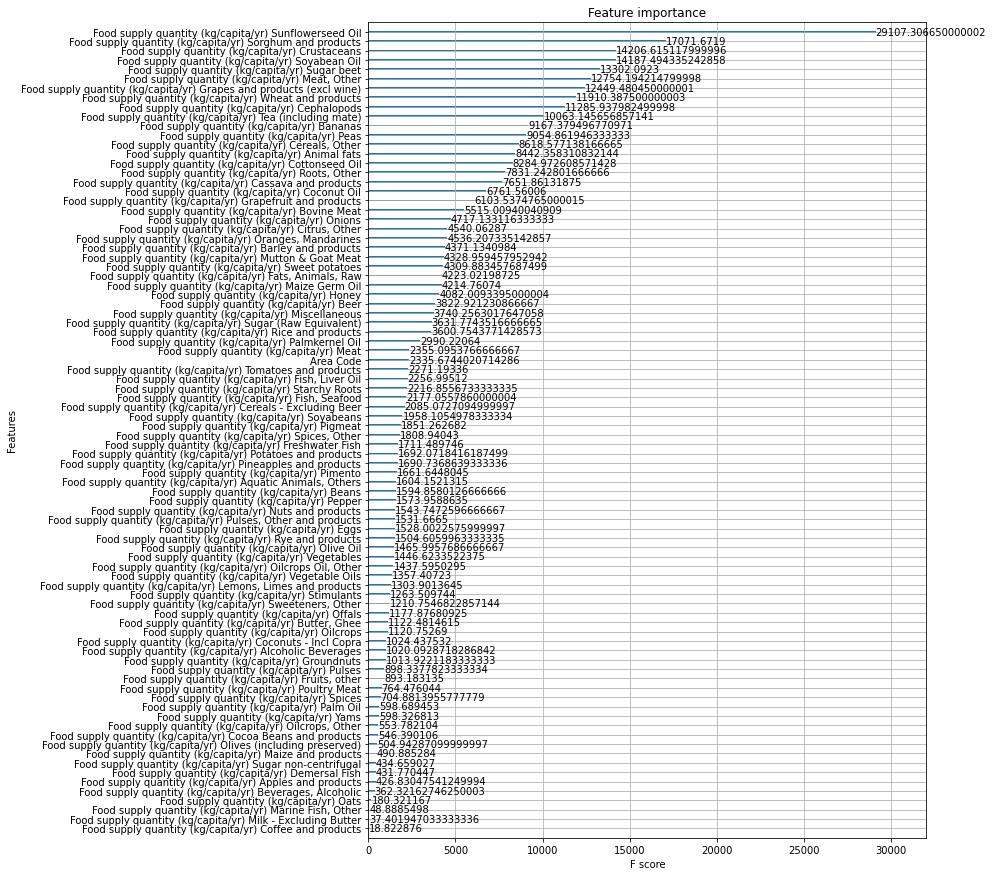

In [565]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}


fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

In [577]:
df_impo = pd.DataFrame(importance.items(), columns=['Item', 'Importance']).reset_index()
df_impo.sort_values(by="Importance",  ascending=False).head(8)

,index,Item,Importance
85,85,Food supply quantity (kg/capita/yr) Sunflowerseed Oil,29107.306650
84,84,Food supply quantity (kg/capita/yr) Sorghum and products,17071.671900
83,83,Food supply quantity (kg/capita/yr) Crustaceans,14206.615118
82,82,Food supply quantity (kg/capita/yr) Soyabean Oil,14187.494335
81,81,Food supply quantity (kg/capita/yr) Sugar beet,13302.092300
80,80,"Food supply quantity (kg/capita/yr) Meat, Other",12754.194215
79,79,Food supply quantity (kg/capita/yr) Grapes and products (excl wine),12449.480450
78,78,Food supply quantity (kg/capita/yr) Wheat and products,11910.387500


Text(0.5, 1.0, 'Food supply quantity (kg/capita/yr) and their Importance % over the model \n')

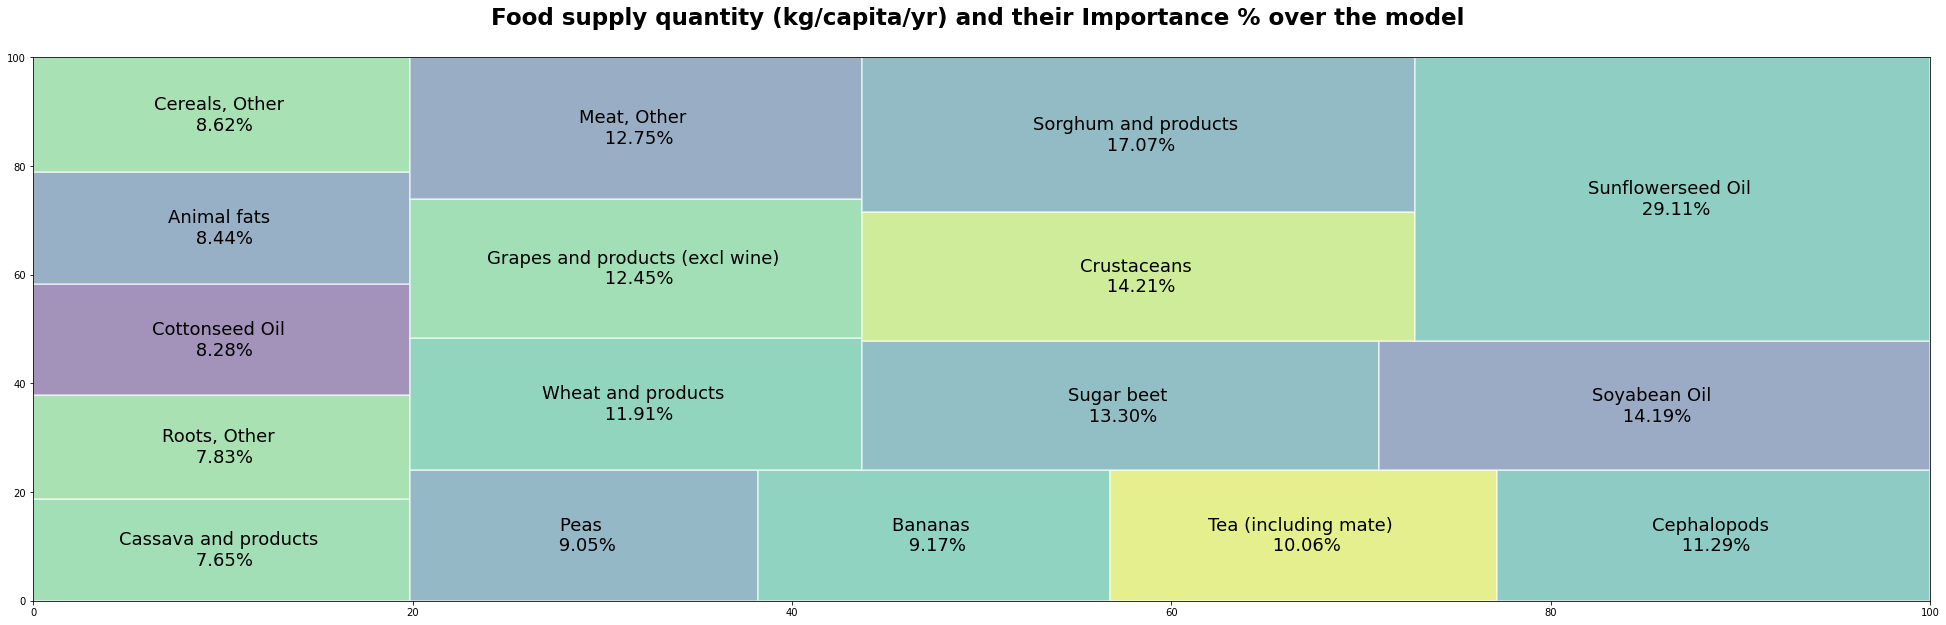

In [584]:

#libraries
import matplotlib.pyplot as plt
import squarify # pip install squarify (algorithm for treemap)
 
# Change color
# squarify.plot(sizes=[13,22,35,5], label=["group A", "group B", "group C", "group D"], color=["red","green","blue", "grey"], alpha=.4 )
# plt.axis('off')
# plt.show()
# values and labels
# values and labels
df_impo["Item"] = df_impo["Item"].str.replace('Food supply quantity (kg/capita/yr) ', '', regex=False)
df_impo = df_impo[df_impo["Importance"]> df_impo["Importance"].sum()*(2/100)]
my_values = df_impo["Importance"]
my_pct = df_impo["Importance"]/df_impo["Importance"].sum()
labels = ['{} \n {:.2f}%'.format(Item , Importance/1000, pct*100) for Item , Importance, pct in zip(df_impo.Item, my_values, my_pct)]

#plot
plt.figure(figsize = (34, 10))
squarify.plot(sizes = my_values, label = labels,edgecolor="white", linewidth=2,  alpha = 0.5, text_kwargs={'fontsize':18,'color':"black"})
plt.title("Food supply quantity (kg/capita/yr) and their Importance % over the model \n",fontsize = 23, fontweight = "bold")


In [561]:
from sklearn import metrics
from math import sqrt
Y_valida_pred = model.predict(X_valida)

r2_valida = sqrt(metrics.r2_score(Y_valida, Y_valida_pred))
rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
print("rmse",rmse_valida)
print("r2",r2_valida)

rmse 14.88474570982412
r2 0.639691556303435


Accuracy: 7.80%


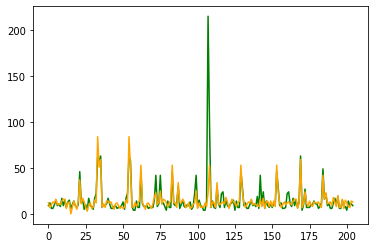

In [562]:
### to dos : quitar valores negativos_=?

### to dos : dividir emisiones per capita para dimensionarlos correctamente
index=0;
min_value = Y_valida_pred.min()
offset= 0-min_value

Y_valida_pred_off = Y_valida_pred+offset

min_value_valida = Y_valida.min()
offset_valida= 0-min_value_valida

Y_valida_off= Y_valida+offset



predictions = [round(value) for value in Y_valida_pred_off]
Y_valida_off = [round(value) for value in Y_valida_off]
# evaluate predictions
accuracy = metrics.accuracy_score(Y_valida_off, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#plot each series
plt.plot(Y_valida_off, label='Real', color='green')
plt.plot(predictions, label='Prediction', color='orange')


#display plot
plt.show()